In [1]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
plt.ioff()
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from itertools import product
from tqdm import tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


$x_{t+1} = (A + pB)x_t + Cu$

In [2]:
def passivity(t,k=0.05,t0=400):
    return 1/(1+np.exp(-k*(t-t0)))

def diag_idx(n):
    return [i for i in range(n)],[i for i in range(n)]

def makeStableMatrix(n, density=0.1):
    # TODO: implement on GPU?
    eig = np.diag(np.random.uniform(-1,0,n))
    v = scipy.linalg.orth(np.random.uniform(-1,1,(n,n)))
    A = v.T @ eig @ v
    # need to make A sparse
    indices = np.reshape(np.indices((n,n)),[2,-1])
    mask = np.eye(n)
    # may create density slightly less than desired if choice is on diagonal
    idx = indices[:,np.random.choice(np.arange(indices.shape[1]),int(np.ceil(density*n**2-n)),replace=False)]
    mask[idx[0], idx[1]] = 1
    A[np.logical_not(mask)] = 0
    return A

def step(A,B,C,u,p,x,dt=1):
    dxdt = (A + p*B) @ x + C * u
    return dxdt + x

def step_batch(A,B,C,u,p,x,dt=1):
    dxdt = ((A + p[:,None,None]*B) @ x[:,:,None]).squeeze() + u[:,None]*C
    return dxdt + x

def sim(A,B,C,u,p,x0,e=0.05):
    ntime = u.shape[0]
    nfeatures = x0.shape[0]
    time = T.arange(ntime,dtype=T.int32)
    x = T.zeros(ntime, x0.shape[0]).cuda()
    z = T.zeros(nfeatures).cuda()
    x[0] = x0
    for t in range(1,ntime):
        if e==0:
            x[t] = step(A,B,C,u[t],p[t],x[t-1])
        else:
            x[t] = step(A,B,C,u[t],p[t],x[t-1]) + T.normal(z,e).cuda()
    return x

def generate_data(sim_time, nstim,nfeatures, burn_in=400, test_time=200, e=0.01, k=0.05, t0=400, density=0.2):
    ntime = sim_time+burn_in+test_time
    time = T.from_numpy(np.arange(ntime)).cuda()
    A_true = T.from_numpy(makeStableMatrix(nfeatures,density).astype(np.float32)).cuda()
    B_true = T.from_numpy(makeStableMatrix(nfeatures,density).astype(np.float32)).cuda()
    C_true = T.from_numpy(np.random.normal(0,0.05,nfeatures).astype(np.float32)).cuda()
    # C_true = T.from_numpy(makeStableMatrix(nfeatures).astype(np.float32)).cuda()
    x0 = T.from_numpy(np.random.normal(0,0.05,nfeatures).astype(np.float32)).cuda()
    u = T.zeros(ntime).cuda()
    u[np.arange(4,ntime,ntime/nstim)] = 1

    p1 = np.vectorize(partial(passivity,k=k,t0=t0))
    time = np.arange(ntime)
    p_true = p1(time).astype(np.float32)
    p_true = T.from_numpy(p_true).cuda()
#     p_true = T.zeros(ntime).cuda() # TODO remove me
    x_true = sim(A_true,B_true,C_true,u,p_true,x0,e)
    train = (time[burn_in:-test_time], u[burn_in:-test_time],
             p_true[burn_in:-test_time], x_true[burn_in:-test_time])
    test = (time[-test_time:], u[-test_time:], p_true[-test_time:], x_true[-test_time:])
    return A_true, B_true, C_true, train, test

In [3]:
class FishSeqData(Dataset):    
    def __init__(self, u, p, x,n_future_steps=1):
        self.x = nn.Parameter(x,requires_grad=False)
        self.p = nn.Parameter(p,requires_grad=False)
        self.u = nn.Parameter(u,requires_grad=False)
        self.nfeatures = x.shape[1]
        self.n_future_steps = n_future_steps
        
    def __len__(self):
        return len(self.x)-self.n_future_steps

    def __getitem__(self, idx):
        indices = slice(idx,idx+self.n_future_steps)
        x_true_indices = slice(idx+1,idx+self.n_future_steps+1)
        return (self.u[indices], self.p[indices],
                self.x[indices], self.x[x_true_indices])

class DynamicsSeq(nn.Module):
    def __init__(self, nfeatures, n_future_steps):
        super(DynamicsSeq, self).__init__()
        self.A = nn.Parameter(T.normal(T.zeros(nfeatures,nfeatures),0.5),requires_grad=True)
        self.B = nn.Parameter(T.normal(T.zeros(nfeatures,nfeatures),0.5),requires_grad=True)
        self.C = nn.Parameter(T.normal(T.zeros(nfeatures),0.5),requires_grad=True)
        self.n_future_steps = n_future_steps

    def forward(self, u, p, x_true, n_future_steps=None):
        if n_future_steps==None:
            n_future_steps = self.n_future_steps
        x = T.zeros(x_true.shape[0], 1+x_true.shape[1], *x_true.shape[2:]).cuda()
        x[:,0] = x_true[:,0]
        for t in range(n_future_steps):
            dxdt = ((self.A + p[:,t,None,None]*self.B) @ x_true[:,t,:,None]).squeeze() + u[ :,t,None]*self.C
            x[:,t+1] = dxdt + x[:,t]
        return x[:,1:]


def train(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6),
          lr=0.001, verbose=True, silent=False):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    if verbose and not silent:
        A_loss = F.mse_loss(model.A.data,A_true)
        print(f"A_loss: {A_loss}")
#     optimizer = T.optim.Adam(model.parameters(),lr=lr)
    optimizer = T.optim.SGD(model.parameters(), lr=lr)
#     noise = T.distributions.Normal(0,0.2)
    for e in range(nepochs):
        if verbose and not silent:
            print(f"epoch {e}: ", end="")
        cum_loss = 0

        for batch_data in dataloader:
            U,P,X, X_true = batch_data
#             X_noised = X + noise.sample(T.Size([data.nfeatures])).cuda()
            optimizer.zero_grad()
            X_pred = model(U,P,X)
#             l1_reg = T.zeros(1, requires_grad=True).cuda()
#             for W in model.parameters():
#                 l1_reg = l1_reg + W.norm(1)
            l_A = lambdaA[0] * model.A.norm(1) + lambdaA[1] * model.A.norm(2)
            l_B = lambdaB[0] * model.B.norm(1) + lambdaB[1] * model.B.norm(2)
            mse_loss = F.mse_loss(X_pred,X_true)
            loss = mse_loss + l_A + l_B
            cum_loss += mse_loss.cpu().detach().numpy()
            loss.backward()
            optimizer.step()

        A_loss = F.mse_loss(model.A.data,A_true)
        B_loss = F.mse_loss(model.B.data,B_true)
        C_loss = F.mse_loss(model.C.data,C_true)
        if verbose and not silent:
            print(f"pred_loss: {cum_loss}, A_loss: {A_loss}, B_loss: {B_loss}, C_loss: {C_loss}")
    if not silent:
        print(f"FINAL: pred_loss: {cum_loss}, A_loss: {A_loss}, B_loss: {B_loss}, C_loss: {C_loss}")

def model_v_truth(model,u,p,x_true,A_true, B_true):
    A = model.A.data
    B = model.B.data
    with T.no_grad():
        x_pred = T.squeeze(model(u[:-1,None],p[:-1,None],x_true[:-1,None],n_future_steps=1))
    fig = plt.figure(figsize=(10,10))
    spec = gridspec.GridSpec(ncols=2, nrows=3)
    anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction',
                     va='center', ha='center')

    ax1 = fig.add_subplot(spec[0,0:])
    ax2 = fig.add_subplot(spec[1, 0])
    ax3 = fig.add_subplot(spec[1, 1])
    ax4 = fig.add_subplot(spec[2, 0])
    ax5 = fig.add_subplot(spec[2, 1])
    
    dx_pred = x_pred - x_true[:-1]
    ax1.plot(dx_pred.mean(1).cpu().numpy(),color='red', label="Model")
#     ax1.plot(x_pred[:,2].cpu().numpy(),color='red', label="Model")
    ax1.set_ylabel("dx/dt")
    ax1.set_xlabel("Time")
    ax1.set_title("Witheld test data")
    dx_true = x_true[1:] - x_true[:-1]
    ax1.plot(dx_true.mean(1).cpu().numpy(),color="gray",linewidth=5, alpha=0.7,label="Truth")
    ax1.legend()
    
    mymax = max(A_true.max(), A.max())
    mymin = min(A_true.min(), A.min())
    im = ax2.imshow(A_true.cpu(),vmin=mymin,vmax=mymax)
    ax2.set_title("A true")
    ax3.imshow(A.cpu(),vmin=mymin,vmax=mymax)
    ax3.set_title("A model")
#     cax,kw = mpl.colorbar.make_axes([ax2, ax3])
#     fig.colorbar(im, cax=cax, **kw)
    
    mymax = max(B_true.max(), B.max())
    mymin = min(B_true.min(), B.min())
    im2 = ax4.imshow(B_true.cpu(),vmin=mymin,vmax=mymax)
    ax4.set_title("B true")
    ax5.imshow(B.cpu(),vmin=mymin,vmax=mymax)
    ax5.set_title("B model")
#     cax,kw = mpl.colorbar.make_axes([ax4, ax5])
#     fig.colorbar(im2, cax=cax, **kw)
    
    fig.tight_layout()
    return fig

# Reconstruction performance

In [4]:
def generate_data_no_stim(sim_time,nfeatures, burn_in=400, e=0.01, t0=400, density=0.2):
    ntime = int(sim_time+burn_in)
    time = T.from_numpy(np.arange(ntime)).cuda()
    A_true = T.from_numpy(makeStableMatrix(nfeatures,density).astype(np.float32)).cuda()
    B_true = T.cuda.FloatTensor(nfeatures,nfeatures).zero_()
    C_true = T.cuda.FloatTensor(nfeatures).zero_()

    x0 = T.from_numpy(np.random.normal(0,0.05,nfeatures).astype(np.float32)).cuda()
    u = T.cuda.FloatTensor(ntime).zero_()

    p_true = T.cuda.FloatTensor(ntime).zero_()
    x_true = sim(A_true,B_true,C_true,u,p_true,x0,e)
    train = (time[burn_in:], u[burn_in:],
             p_true[burn_in:], x_true[burn_in:])
    return A_true, B_true, C_true, train

nfeatures = 50
n_future_steps = 1
batch_size = 64

times = np.arange(100,1100,100)
noises = np.arange(0,0.1,0.01)
nTime = len(times)
nNoise = len(noises)
mse = np.zeros([nNoise, nTime])

for ((t,time),(n,noise)) in tqdm(product(enumerate(times),enumerate(noises))):
    A_true, B_true, C_true, train_data = generate_data_no_stim(time, nfeatures, burn_in=400,
                                                               e=noise, t0=400, density=0.2)
    time_train, u_train, p_train, x_train = train_data
    n_future_steps = 1
    batch_size = 1

    data = FishSeqData(u_train,p_train,x_train,n_future_steps)
    model = DynamicsSeq(data.nfeatures,n_future_steps)
    model.to("cuda")
    train(model,data,15,(1e-4,1e-5),(1e-3,1e-4),lr=0.1,verbose=False,silent=True)
    cur_mse = F.mse_loss(model.A.data,A_true).cpu().numpy()
    mse[n,t] = cur_mse

100it [20:05, 12.06s/it]


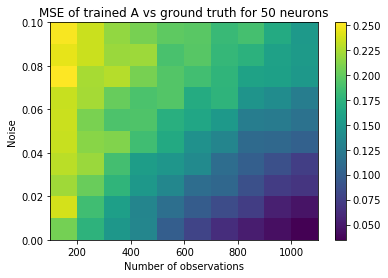

In [8]:
plt.imshow(mse, extent=[min(times),max(times)+times[1]-times[0], 
                        min(noises),max(noises)+noises[1]-noises[0]], aspect='auto')
plt.title(f"MSE of trained A vs ground truth for {nfeatures} neurons")
plt.xlabel("Number of observations")
plt.ylabel("Noise")
plt.colorbar()
plt.show()

# Generate data

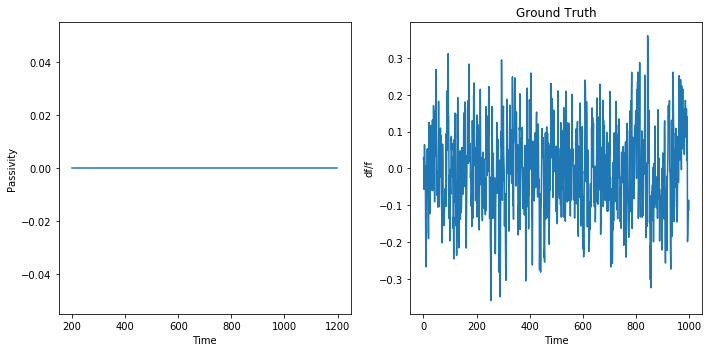

In [9]:
ntime = 1000
nstim = 30
nfeatures = 100
A_true, B_true, C_true, train_data, test_data = generate_data(ntime, nstim,nfeatures,burn_in=200, e=0.1,k=1,t0=1e10)
time_train, u_train, p_train, x_train = train_data
time_test, u_test, p_test, x_test = test_data

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(time_train,p_train.cpu().numpy())
ax[0].set_ylabel("Passivity")
ax[0].set_xlabel("Time")

ax[1].plot(x_train[:,2].cpu().numpy())
ax[1].set_title("Ground Truth")
ax[1].set_ylabel("df/f")
ax[1].set_xlabel("Time")
fig.tight_layout()
fig

A_loss: 0.25563398003578186
epoch 0: pred_loss: 360.05052207410336, A_loss: 0.2339976578950882, B_loss: 0.176237553358078, C_loss: 0.18544910848140717
epoch 1: pred_loss: 326.3967799991369, A_loss: 0.21409814059734344, B_loss: 0.12413596361875534, C_loss: 0.17219823598861694
epoch 2: pred_loss: 295.97973500192165, A_loss: 0.19579370319843292, B_loss: 0.08568011224269867, C_loss: 0.16037769615650177
epoch 3: pred_loss: 268.42350293695927, A_loss: 0.17895449697971344, B_loss: 0.05794660747051239, C_loss: 0.1497955322265625
epoch 4: pred_loss: 243.51884028315544, A_loss: 0.1634625494480133, B_loss: 0.03848002478480339, C_loss: 0.14028261601924896
epoch 5: pred_loss: 220.88693744689226, A_loss: 0.14921550452709198, B_loss: 0.025152042508125305, C_loss: 0.13169439136981964
epoch 6: pred_loss: 200.44980870187283, A_loss: 0.13611099123954773, B_loss: 0.01630358211696148, C_loss: 0.12388325482606888
epoch 7: pred_loss: 181.91755145043135, A_loss: 0.1240614727139473, B_loss: 0.01062863133847713

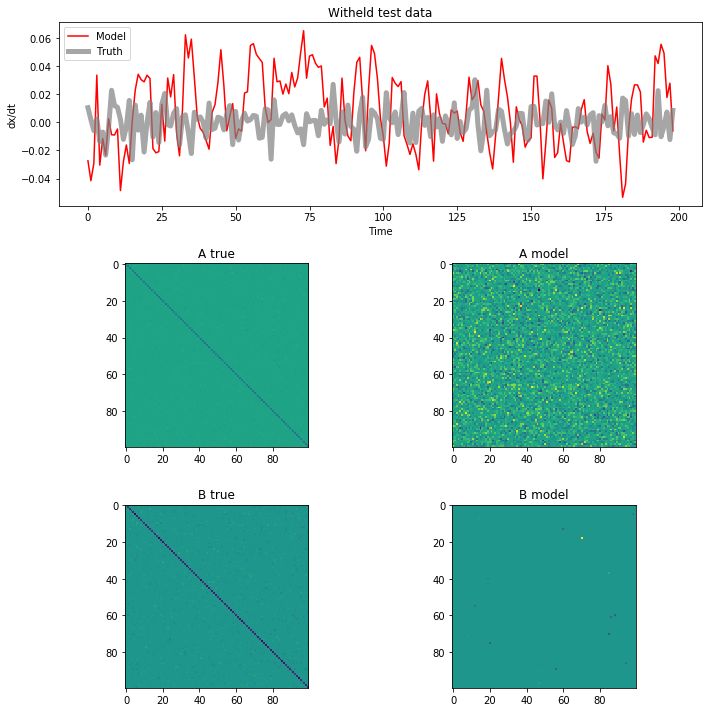

In [10]:
n_future_steps = 1
batch_size = 1

data = FishSeqData(u_train,p_train,x_train,n_future_steps)
model = DynamicsSeq(data.nfeatures,n_future_steps)
model.to("cuda")
train(model,data,15,(1e-4,1e-5),(1e-3,1e-4),lr=0.1)
model_v_truth(model, *test_data[1:], A_true.data, B_true.data)

In [42]:
A_true

tensor([[-0.3587,  0.0000,  0.0000,  0.0000, -0.1470,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.5243,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.2386,  0.0000,  0.0000, -0.0183,  0.0025,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.3320,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.3498,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.4217,  0.0000,
          0.0000, -0.0535,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0052, -0.4134,
          0.0000,  0.0000,  0.0000],
        [-0.0188,  0.0000, -0.0048,  0.0000,  0.0000,  0.0000, -0.0625,
         -0.3254,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.3452,  0.0000],
        [ 0.0078,  

In [41]:
model.A

Parameter containing:
tensor([[-0.3199, -0.0077, -0.0030, -0.0012, -0.1282,  0.0028, -0.0036,
         -0.0057, -0.0010, -0.0084],
        [ 0.0057, -0.4856,  0.0036,  0.0040, -0.0035, -0.0041, -0.0053,
         -0.0003, -0.0008,  0.0011],
        [-0.0002, -0.0004, -0.2089, -0.0043, -0.0006, -0.0049, -0.0062,
         -0.0006,  0.0071,  0.0007],
        [ 0.0005, -0.0018,  0.0120, -0.2955, -0.0080,  0.0020,  0.0197,
          0.0153, -0.0003, -0.0007],
        [ 0.0172,  0.0002,  0.0011,  0.0002, -0.3151,  0.0485,  0.0014,
          0.0003, -0.0083, -0.0056],
        [-0.0036,  0.0014, -0.0046, -0.0006,  0.0002, -0.3974, -0.0043,
         -0.0009, -0.0270, -0.0013],
        [ 0.0070, -0.0015,  0.0026,  0.0022,  0.0098, -0.0022, -0.3808,
         -0.0003,  0.0147, -0.0066],
        [-0.0034,  0.0202,  0.0137, -0.0001, -0.0017,  0.0005, -0.0111,
         -0.2911, -0.0026, -0.0013],
        [ 0.0036, -0.0001,  0.0013, -0.0044,  0.0001, -0.0011, -0.0255,
          0.0002, -0.3079,  0.0048

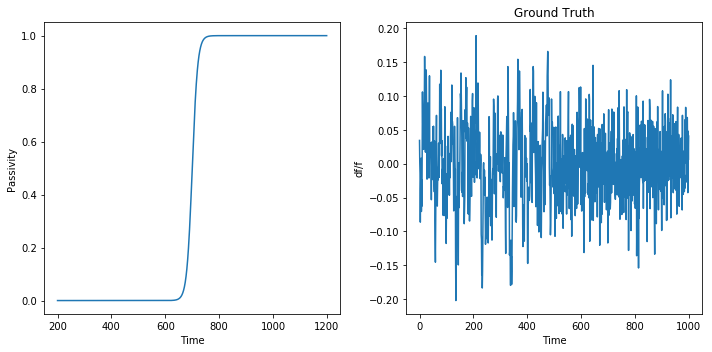

In [18]:
ntime = 1000
nstim = 30
nfeatures = 10
A_true, B_true, C_true, train_data, test_data = generate_data(ntime, nstim,nfeatures,burn_in=200, e=0.05,k=0.1,t0=700)
time_train, u_train, p_train, x_train = train_data
time_test, u_test, p_test, x_test = test_data

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(time_train,p_train.cpu().numpy())
ax[0].set_ylabel("Passivity")
ax[0].set_xlabel("Time")

ax[1].plot(x_train[:,2].cpu().numpy())
ax[1].set_title("Ground Truth")
ax[1].set_ylabel("df/f")
ax[1].set_xlabel("Time")
fig.tight_layout()
fig

In [ ]:
n_future_steps = 1
batch_size = 5

data = FishSeqData(u_train,p_train,x_train,n_future_steps)
model = DynamicsSeq(data.nfeatures,n_future_steps)
model.to("cuda")
train(model,data,40,2e-5,2e-5,lr=0.001)
model_v_truth(model, *test_data[1:], A_true.data, B_true.data)

# 100 features

In [ ]:
ntime = 1000
nstim = 30
nfeatures = 10000
A_true, B_true, C_true, train_data, test_data = generate_data(ntime, nstim,nfeatures,burn_in=200, e=0.05,k=0.1,t0=500)
time_train, u_train, p_train, x_train = train_data
time_test, u_test, p_test, x_test = test_data

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(time_train,p_train.cpu().numpy())
ax[0].set_ylabel("Passivity")
ax[0].set_xlabel("Time")

ax[1].plot(x_train[:,2].cpu().numpy())
ax[1].set_title("Ground Truth")
ax[1].set_ylabel("df/f")
ax[1].set_xlabel("Time")
fig.tight_layout()
fig

In [ ]:
n_future_steps = 1
batch_size = 1

data = FishSeqData(u_train,p_train,x_train,n_future_steps)
model = DynamicsSeq(data.nfeatures,n_future_steps)
model.to("cuda")
train(model,data,6,2e-6,2e-6,lr=0.001)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


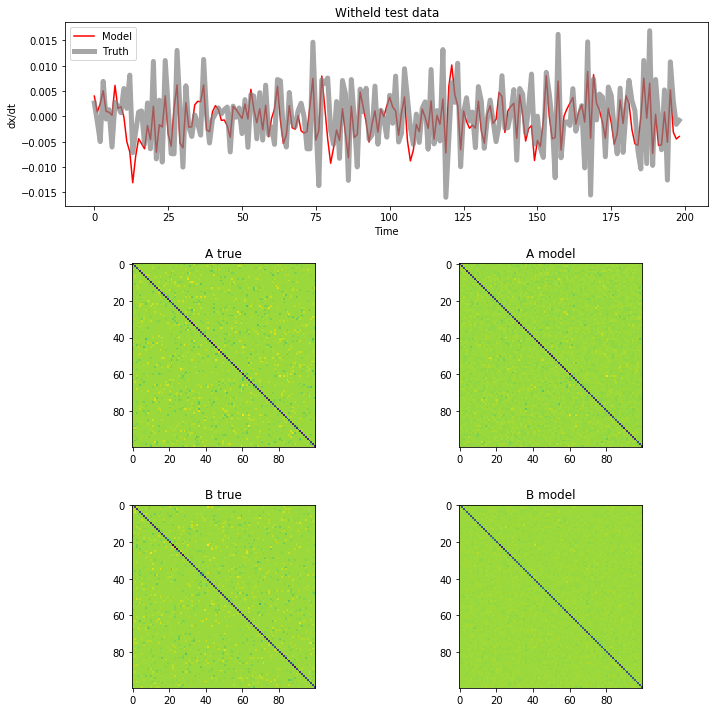

In [246]:
model_v_truth(model, *test_data[1:], A_true.data, B_true.data)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


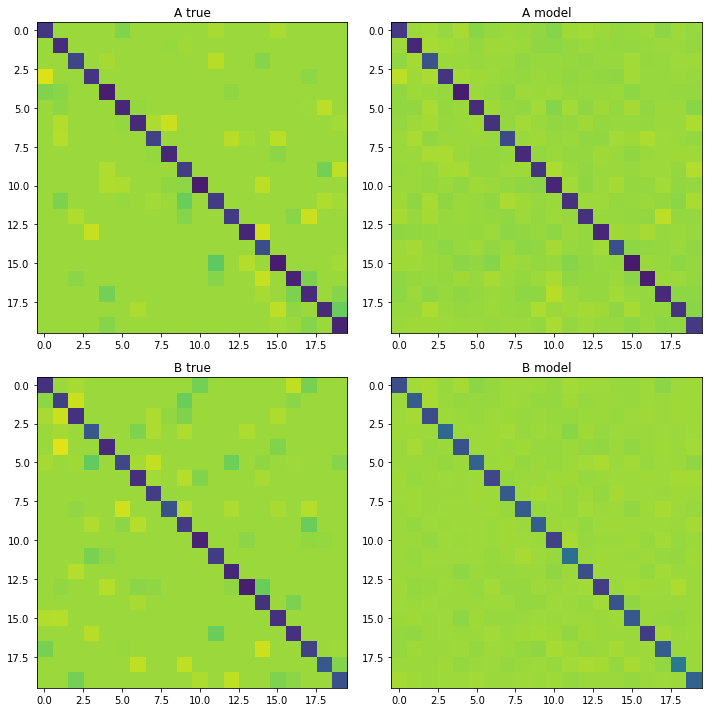

In [248]:
A = model.A.data
B = model.B.data

fig = plt.figure(figsize=(10,10))
spec = gridspec.GridSpec(ncols=2, nrows=2)
anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction',
                 va='center', ha='center')

ax2 = fig.add_subplot(spec[0, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 0])
ax5 = fig.add_subplot(spec[1, 1])

mymax = max(A_true.max(), A.max())
mymin = min(A_true.min(), A.min())
im = ax2.imshow(A_true.cpu()[0:20,0:20],vmin=mymin,vmax=mymax)
ax2.set_title("A true")
ax3.imshow(A.cpu()[0:20,0:20],vmin=mymin,vmax=mymax)
ax3.set_title("A model")
#     cax,kw = mpl.colorbar.make_axes([ax2, ax3])
#     fig.colorbar(im, cax=cax, **kw)

mymax = max(B_true.max(), B.max())
mymin = min(B_true.min(), B.min())
im2 = ax4.imshow(B_true.cpu()[0:20,0:20],vmin=mymin,vmax=mymax)
ax4.set_title("B true")
ax5.imshow(B.cpu()[0:20,0:20],vmin=mymin,vmax=mymax)
ax5.set_title("B model")
#     cax,kw = mpl.colorbar.make_axes([ax4, ax5])
#     fig.colorbar(im2, cax=cax, **kw)

fig.tight_layout()
fig

In [ ]:
10000*10000